In [2]:
import numpy as np
import matplotlib.pyplot as plt

import jax
from functools import partial
import jax.numpy as jnp

plt.rcParams['figure.figsize'] = [12, 8]

import time
from tqdm import tqdm

from Dynamics import logistic_map
from Kernels import ext_kernel
from Losses import rho_comp

from Optimizer import KernelSOS, flow_rho_relative
from DataManager import get_curr_data, sample_points
from utils import get_predict_func, gen_traj, predict_series, get_pred_funcs

jax.config.update("jax_enable_x64", True)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
# Seems np.ones is a good guess for parameters. So a low learning rate is beneficial (1e-3). 

def main_flow(y_idx):
    lr = 0.001
    num_steps = 200

    k_func = ext_kernel

    theta = np.ones(10)

    theta_star, losses = flow_rho_relative(theta, k_func, X_batch, y_batch[:, y_idx], X_sub, y_sub[:, y_idx], num_steps, lr)

    plt.plot(losses)
    print("flow min", np.min(losses))
    return theta_star
    
def main_sos(y_idx):
    # Setup for Kernel SOS.
    thetas = sample_points([[0.001, 5]] * 10, 200)

    loss = lambda t: rho_comp(t, ext_kernel, X_batch, y_batch[:, y_idx], X_sub, y_sub[:, y_idx])

    fs = jnp.array([loss(t) for t in tqdm(thetas)])
    thetas = jnp.array(thetas)

    alpha0 = jnp.ones(len(fs))
    alpha0 /= jnp.sum(alpha0)
    theta_star, res, alpha = KernelSOS(alpha0, thetas, fs, loss, N=100, lmbda=0.0005, eps=0.0001, sig=0.1)
    print("found min", np.min(res[:, 1]))
    print("sample min", np.min(fs))

    plt.plot(res[:, 1])
    return theta_star
    

In [123]:
r = 4
x = 0.1

x_vec_0 = jnp.array([x])



traj_train = jnp.array(gen_traj(logistic_map(r), x_vec_0, 200))

X_train = traj_train[:-1]
Y_train = traj_train[1:]

X_batch, y_batch, X_sub, y_sub = get_curr_data(X_train, Y_train, 200, 100)



# Y.idx 0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:01<00:00,  3.25it/s]


flow min 0.0006071533293211528


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.14it/s]


found min 0.00022056162139161284
sample min 0.00023799877130470382


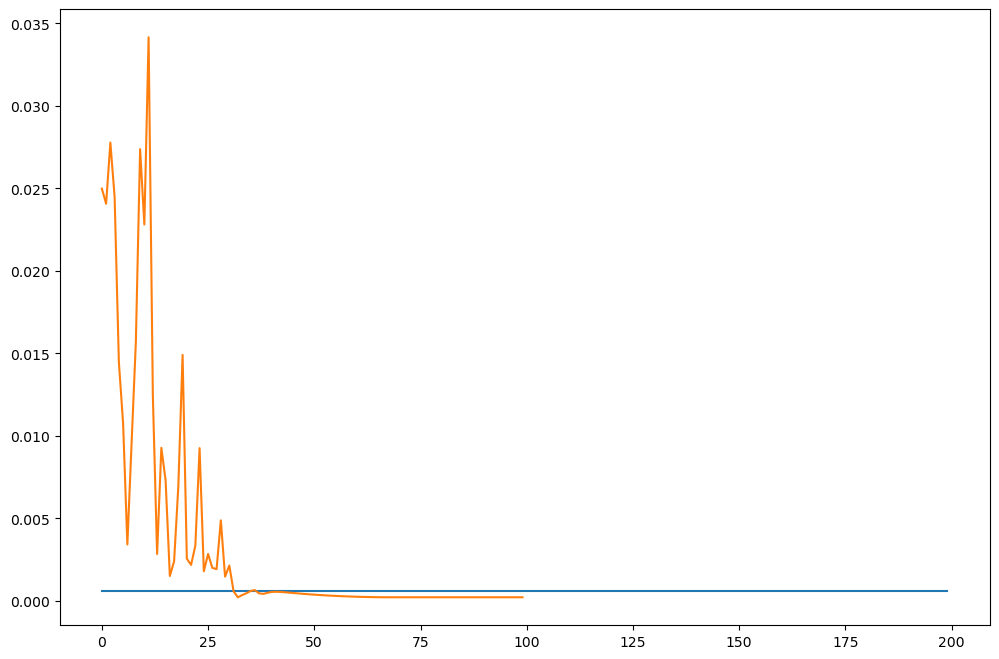

In [124]:
y_idx = 0

theta_star_flow_0 = main_flow(y_idx)
theta_star_sos_0 = main_sos(y_idx)

# Assessment

In [94]:
r = 4

x_vec_0_test = jnp.array([0.3])
# x_vec_0 = jnp.array([-0.75, -0.3])

N_test = 200

traj_test = jnp.array(gen_traj(logistic_map(r), x_vec_0_test, N_test))

X_test = traj_test[:-1]
Y_test = traj_test[1:]

In [95]:
thetas_flow = jnp.array([theta_star_flow_0])
thetas_sos = jnp.array([theta_star_sos_0])

pred_funcs_flow = get_pred_funcs(thetas_flow, ext_kernel, X_train, Y_train)
pred_funcs_sos = get_pred_funcs(thetas_sos, ext_kernel, X_train, Y_train)

# Autoregressive

In [96]:
traj_preds_flow = predict_series(pred_funcs_flow, jnp.array(x_vec_0_test), N_test)
traj_preds_sos = predict_series(pred_funcs_sos, jnp.array(x_vec_0_test), N_test)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 41.59it/s]


In [97]:
print("flow", np.std(np.linalg.norm((traj_test - traj_preds_flow), axis=1)))
print("sos", np.std(np.linalg.norm((traj_test - traj_preds_sos), axis=1)))

flow 0.29709568377401047
sos 0.29127569156644895


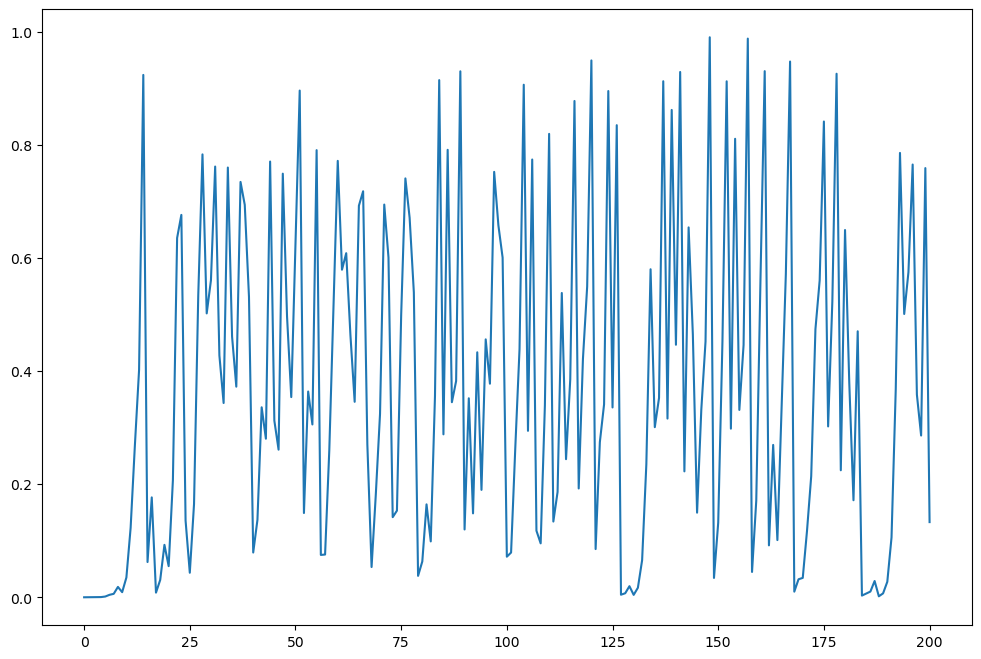

In [98]:
diff = np.linalg.norm((traj_test - traj_preds_sos), axis=1)

plt.plot(diff)
plt.show()

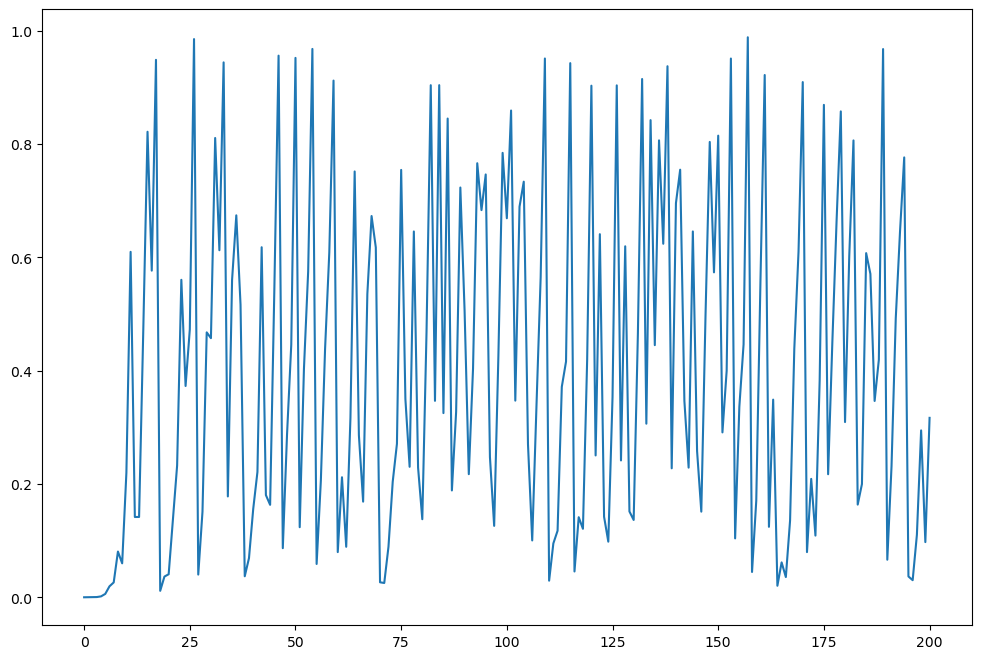

In [99]:
diff = np.linalg.norm((traj_test - traj_preds_flow), axis=1)

plt.plot(diff)
plt.show()

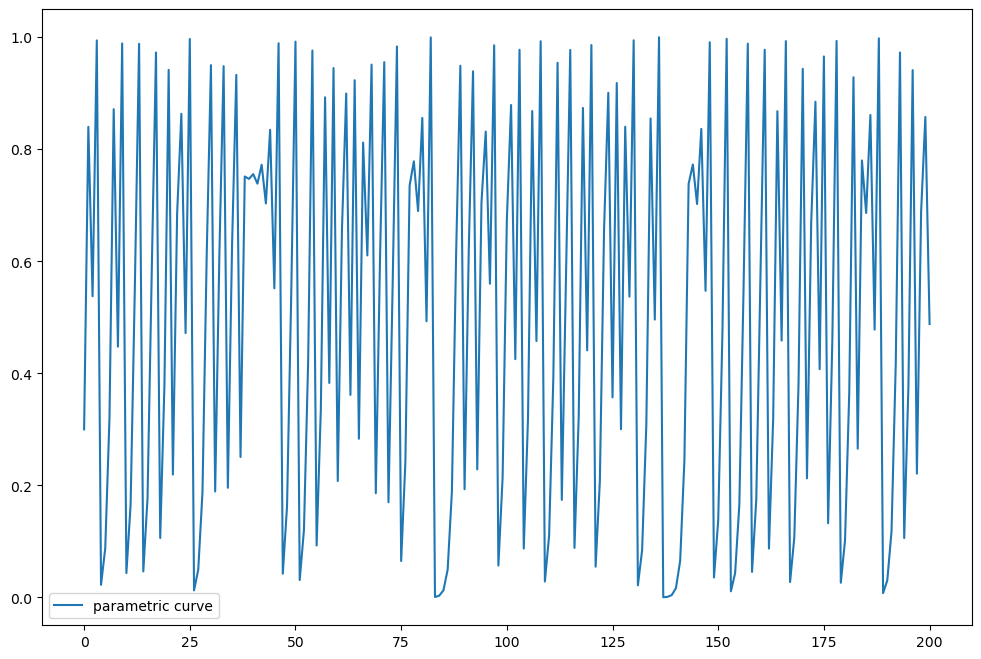

In [100]:

plt.plot(traj_test[:, 0],  label='parametric curve')
plt.legend()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


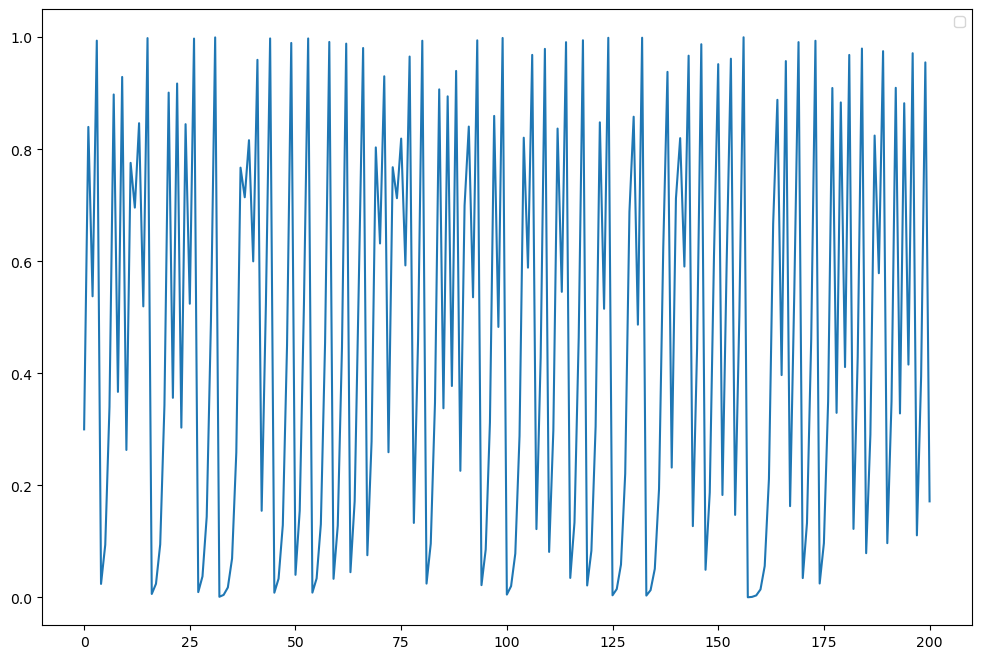

In [101]:
plt.plot(traj_preds_flow[:, 0])
plt.legend()

plt.show()

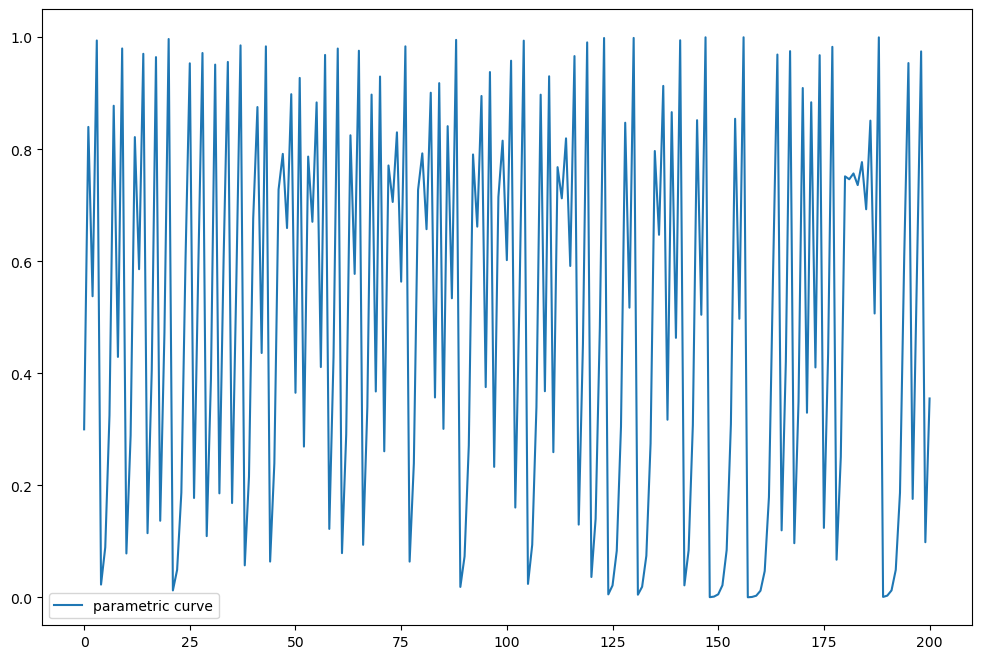

In [102]:
plt.plot(traj_preds_sos[:, 0], label='parametric curve')
plt.legend()

plt.show()

# Non-autoregressive

In [103]:
res_flow = []
res_sos = []
for x in tqdm(X_test):
    curr_res_flow = []
    curr_res_sos = []
    for k in range(1):
        curr_res_flow.append(pred_funcs_flow[k](x))
        curr_res_sos.append(pred_funcs_sos[k](x))
    res_flow.append(curr_res_flow)
    res_sos.append(curr_res_sos)
    
res_flow = jnp.array(res_flow)
res_sos = jnp.array(res_sos)

print("sos", jnp.mean(jnp.linalg.norm(res_sos - Y_test, axis=1)))
print("flow", jnp.mean(jnp.linalg.norm(res_flow - Y_test, axis=1)))




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 18.28it/s]


sos 3.863888667314507e-05
flow 7.780820099809818e-05
